In [6]:
import numpy as np
import pandas as pd

from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVR, LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron, LinearRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score

from src.datasets import load_covid_dataset
from src.shadow_learn import ShadowedSetEstimator
from src.metrics import conservative_score, non_conservative_score, shadow_accuracy

In [7]:
random_state = 42

# Estimator selection

In [3]:
# get a list of models to evaluate
def get_rfes(X_features_num):
    models = dict()
    
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=min(20, int(X_features_num / 2)))
    models['log_regr'] = rfe
    
    rfe = RFE(estimator=Perceptron(), n_features_to_select=min(20, int(X_features_num / 2)))
    models['perc'] = rfe
    
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=min(20, int(X_features_num / 2)))
    models['dec_tr'] = rfe
    
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=min(20, int(X_features_num / 2)))
    models['rnd_for'] = rfe
    
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=min(20, int(X_features_num / 2)))
    models['grd_boost'] = rfe
    
    rfe = RFE(estimator=SVR(kernel='linear'), n_features_to_select=min(20, int(X_features_num / 2)))
    models['svr'] = rfe
    
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(feature_selector, X, y, labels, scoring):
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        'C0': np.concatenate((np.logspace(-2, 1, 5), [])),
        'C1': np.concatenate((np.logspace(-2, 1, 5), [])),
        'sigma': np.concatenate((np.logspace(-1, 2, 5), []))
    }
    gs = GridSearchCV(estimator=ShadowedSetEstimator(),
                      param_grid=param_grid, scoring=scoring,
                      cv=cv_inner, n_jobs=2, verbose=0)
    
    results = []
    
    for train_index, test_index in cv_outer.split(X, labels):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        feature_selector.fit(X_train, y_train)
        X_train = feature_selector.transform(X_train)
        X_test = feature_selector.transform(X_test)
        
        gs.fit(X_train, y_train)
        final_model = gs.best_estimator_
        results.append(scoring(final_model, X_test, y_test))
        
    return np.array(results)

## All features (conservative)


--------------------------------------------
--------------------------------------------

Using license file C:\Users\gabri\gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-08
>log_regr 0.741 (0.061)
scores: [0.63934426 0.81666667 0.75       0.78333333 0.71666667]
>perc 0.741 (0.056)
scores: [0.67213115 0.81666667 0.78333333 0.75       0.68333333]
>dec_tr 0.708 (0.016)
scores: [0.68852459 0.71666667 0.7        0.73333333 0.7       ]
>rnd_for 0.698 (0.019)
scores: [0.68852459 0.71666667 0.7        0.71666667 0.66666667]
>grd_boost 0.737 (0.050)
scores: [0.75409836 0.68333333 0.81666667 0.75       0.68333333]
>svr 0.721 (0.051)
scores: [0.63934426 0.75       0.76666667 0.76666667 0.68333333]


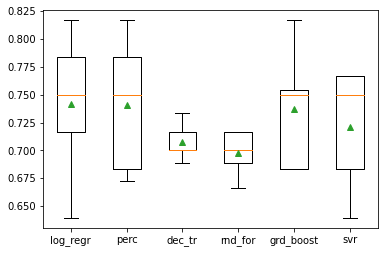

In [4]:
X, y, data_labels, target, column_names = load_covid_dataset(target=0)
# get the models to evaluate
rfes = get_rfes(X.shape[1])
# evaluate the models and store results
results, names = list(), list()
for name, rfe in rfes.items():
    scores = evaluate_model(rfe, X, y, data_labels, make_scorer(conservative_score))
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    print('scores: ' + str(scores))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## All features (non-conservative)

>log_regr 0.718 (0.063)
scores: [0.63934426 0.81666667 0.75       0.66666667 0.71666667]
>perc 0.741 (0.056)
scores: [0.67213115 0.81666667 0.78333333 0.75       0.68333333]
>dec_tr 0.708 (0.036)
scores: [0.67213115 0.75       0.7        0.75       0.66666667]
>rnd_for 0.708 (0.041)
scores: [0.63934426 0.75       0.7        0.75       0.7       ]
>grd_boost 0.715 (0.062)
scores: [0.63934426 0.68333333 0.81666667 0.75       0.68333333]
>svr 0.715 (0.062)
scores: [0.60655738 0.75       0.76666667 0.76666667 0.68333333]


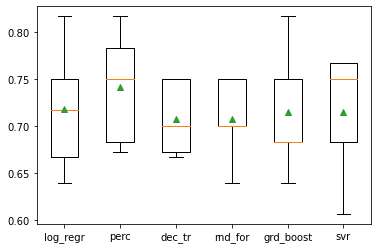

In [5]:
X, y, data_labels, target, column_names = load_covid_dataset(target=0)
# get the models to evaluate
rfes = get_rfes(X.shape[1])
# evaluate the models and store results
results, names = list(), list()
for name, rfe in rfes.items():
    scores = evaluate_model(rfe, X, y, data_labels, make_scorer(non_conservative_score))
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    print('scores: ' + str(scores))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Vs Shadow

In [11]:
# evaluate a give model using cross-validation
def evaluate_model(estimator, feature_selector, X, y, y_shadow, labels, scoring, shadow_test=False):
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        'C0': np.concatenate((np.logspace(-2, 1, 5), [])),
        'C1': np.concatenate((np.logspace(-2, 1, 5), [])),
        'sigma': np.concatenate((np.logspace(-1, 2, 5), []))
    }
    gs = GridSearchCV(estimator=estimator,
                      param_grid=param_grid, scoring=scoring,
                      cv=cv_inner, n_jobs=2, verbose=0)
    
    results = []
    
    for train_index, test_index in cv_outer.split(X, labels):
        if shadow_test:
            y_shadow_train = y_shadow[train_index]
            y_shadow_test = y_shadow[test_index]
        else:
            y_shadow_train = None
            y_shadow_test = None
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        feature_selector.fit(X_train, y_train)
        X_train = feature_selector.transform(X_train)
        X_test = feature_selector.transform(X_test)
        
        full_X_train = X_train.copy()
        full_y_train = y_train.copy()

        fit_params = {
            'full_y_shadow': (y_shadow_train, 1),
            'cv_num': 5,
            'random_state': random_state,
            'full_X': (full_X_train, 1),
            'full_y': (full_y_train, 1)
        }
        
        gs.fit(X_train, y_train, **fit_params)
        final_model = gs.best_estimator_
        if shadow_test:
            final_model_preds = final_model.predict(X_test)
            results.append(accuracy_score(y_shadow_test, final_model_preds))
        else:
            results.append(scoring(final_model, X_test, y_test))
        
    return np.array(results)

## Shadow accuracy

>log_regr 0.505 (0.042)
scores: [0.55737705 0.53333333 0.43333333 0.5        0.5       ]
>perc 0.498 (0.037)
scores: [0.49180328 0.53333333 0.43333333 0.53333333 0.5       ]
>dec_tr 0.492 (0.066)
scores: [0.39344262 0.53333333 0.45       0.58333333 0.5       ]
>rnd_for 0.482 (0.048)
scores: [0.40983607 0.5        0.45       0.55       0.5       ]
>grd_boost 0.485 (0.063)
scores: [0.39344262 0.5        0.45       0.58333333 0.5       ]
>svr 0.488 (0.047)
scores: [0.50819672 0.56666667 0.43333333 0.45       0.48333333]


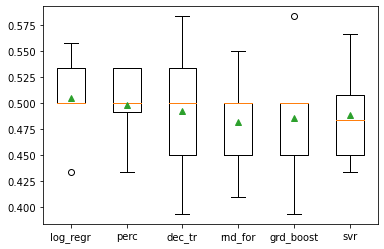

In [13]:
X, y, y_shadow, labels, shadow_labels, target, column_names = load_covid_dataset(target=0, shadow_label='LABEL-3')
# get the models to evaluate
rfes = get_rfes(X.shape[1])
# evaluate the models and store results
results, names = list(), list()
estimator = ShadowedSetEstimator()
for name, rfe in rfes.items():
    scores = evaluate_model(estimator, rfe, X, y, y_shadow, labels, shadow_accuracy, shadow_test=True)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    print('scores: ' + str(scores))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

# Accuracy (three-value labels)

>log_regr 0.542 (0.049)
scores: [0.54098361 0.58333333 0.45       0.55       0.58333333]
>perc 0.545 (0.029)
scores: [0.59016393 0.53333333 0.5        0.55       0.55      ]
>dec_tr 0.558 (0.052)
scores: [0.62295082 0.51666667 0.48333333 0.6        0.56666667]
>rnd_for 0.568 (0.036)
scores: [0.59016393 0.58333333 0.5        0.6        0.56666667]
>grd_boost 0.565 (0.045)
scores: [0.59016393 0.6        0.48333333 0.6        0.55      ]
>svr 0.571 (0.035)
scores: [0.60655738 0.53333333 0.53333333 0.61666667 0.56666667]


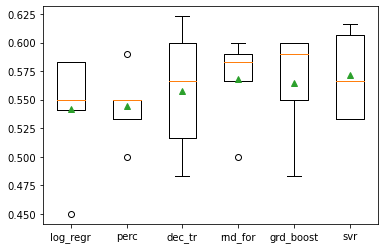

In [14]:
X, y, labels, target, column_names = load_covid_dataset(target=0, shadow_label='LABEL-3', only_shadow=True)
# get the models to evaluate
rfes = get_rfes(X.shape[1])
# evaluate the models and store results
results, names = list(), list()
estimator = ShadowedSetEstimator(solver='gurobi-two-phases-shadow')
for name, rfe in rfes.items():
    scores = evaluate_model(estimator, rfe, X, y, None, labels, make_scorer(accuracy_score))
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    print('scores: ' + str(scores))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()